In [1]:
bigpage = True
from IPython.core.display import display, HTML
if bigpage:
    display(HTML("<style>.container { width:90% !important; }</style>"))
else:
    display(HTML("<style>.container { width:1140px !important; }</style>"))

In [2]:
from accuracy_test import x, y, getFTpoints
x, y = getFTpoints(3, dX=[0.2,0.2,2], rX=[180,180,240])
from  multislice_simulator import file_prefix
from numpy import (log10, sqrt, maximum, minimum, median, pi, arccos, load, argsort,
                   concatenate, array, empty, linalg, linspace, unravel_index, zeros)
from scipy.io import loadmat
%matplotlib notebook
# %matplotlib qt
from matplotlib import pyplot as plt
from FFT_simulator import getFTpoints, planes2basis
from cycler import cycler
import pyxem as pxm
# from pyxem.generators.subpixelrefinement_generator import SubpixelrefinementGenerator
from subpixelrefinement_generator import SubpixelrefinementGenerator
from hyperspy.api import preferences; preferences.General.show_progressbar = False

clist, slist = list('bgrmkcy'), ['-', '--', ':', '-.']
plt.rc('axes', prop_cycle=(cycler('color', clist*len(slist)) + cycler('linestyle', slist*len(clist))))
if bigpage:
    plt.rcParams['figure.figsize'] = [14.9, 6]
else:
    plt.rcParams['figure.figsize'] = [9.5, 6]
def figure(name, *args, **kwargs):
    plt.close(name); f = plt.figure(name, *args, **kwargs);return f

# alpha = 0, 0.5, 1, 2
n, alpha, rotate = 900, .5, False

def plot_FT(thing, *args, origin='lower', **kwargs):
    if thing.ndim == 2:
        plt.imshow(thing, *args, aspect='equal', extent=[y[0][0], y[0][-1], y[1][0], y[1][-1]], origin=origin, **kwargs)
    else:
        plt.plot(y[0], thing, *args, **kwargs)

sqrt = lambda x: x ** .5
def norm(*x):
    if len(x) == 1:
        x = x[0]
    return sqrt(abs(x[0])**2+abs(x[1])**2)

def padSpots(s):
    if s.shape[-1] == 3:
        return s
    else:
        S = empty(s.shape[:-1]+(3,))
        S[...,:2], S[...,2] = s, 0
        return S

In [3]:
gt, DP, strain, inv_strain = {},{},{},{}
stackList = [1,3,10]

for rot in (True,False):
    tmp = loadmat(file_prefix+'_imgs'+str(alpha).replace('.','p')+('_flipped' if rot else '')+'.mat')
    N = tmp['arr0'].shape[0]
    gt[rot] = tuple(x.T/x.max() for x in tmp['arr0'])
    
    DP[rot], strain[rot] = zeros((N,3,3,900,900), dtype='float32'), zeros((3,3), dtype=object)
    for i,I in enumerate((1,2,3)):
        for j,J in enumerate(stackList):
            for k in range(N):
                DP[rot][k,i,j] = tmp['arr'+str(I)+str(J)][k].T
            strain[rot][i,j] = tmp['strain'+str(I)+str(J)]

    DP[rot] /= DP[rot].max(axis=(-1,-2), keepdims=True)
    del tmp # free memory for next load
    

    inv_strain[rot] = empty(strain[rot].shape, dtype='object')
    for i in range(strain[rot].shape[0]):
        for j in range(strain[rot].shape[1]):
            inv_strain[rot][i,j] = linalg.inv(strain[rot][i,j])

spots = {True:array([[1.94,2.73], [1.94,-2.73], [-1.94,2.73], [-1.94,-2.73], [0,5.48], [0,-5.48]])[:,::-1],
         False:concatenate((3.84*array([[1,1], [1,-1], [-1,1],[-1,-1]]), 7.73*array([[0,1], [0,-1], [-1,0],[1,0]])), axis=0)[:,::-1]}



<IPython.core.display.Javascript object>


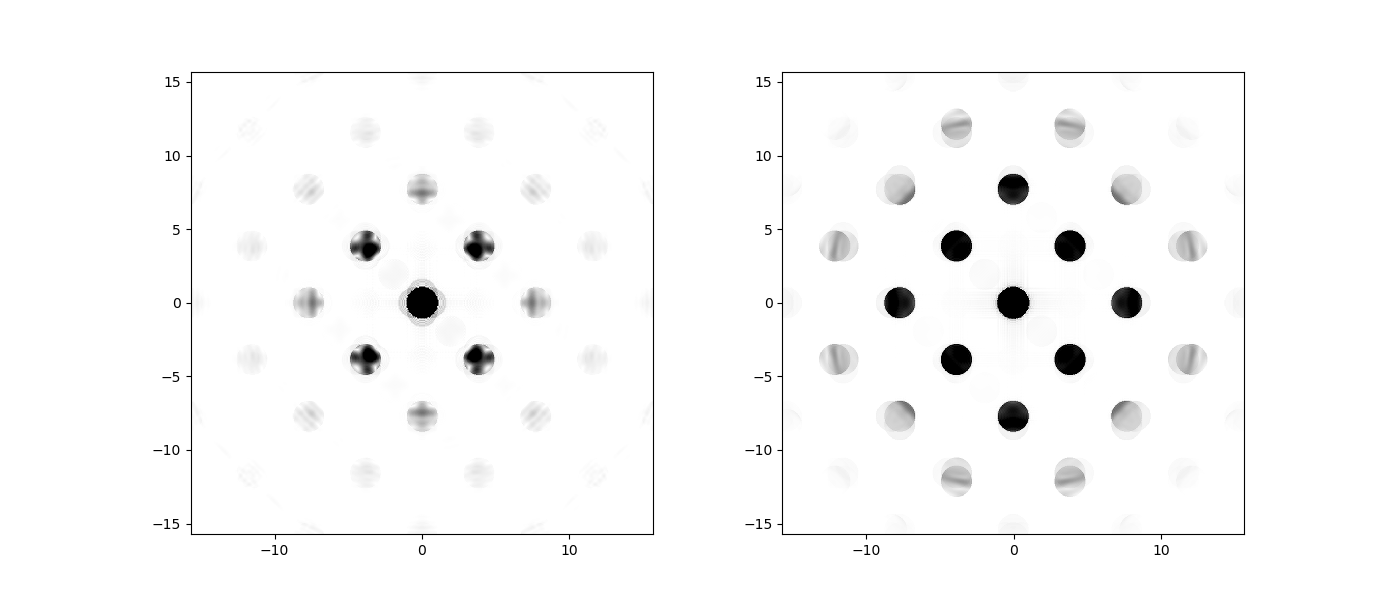

In [4]:
figure('tmp', figsize=(14,6))
rotate = False
thresh, scale =.1, lambda x: 1-maximum(1e-5,minimum(x,thresh))**.5
plt.subplot(121); plot_FT(scale(gt[rotate][0]))
plt.subplot(122); plot_FT(scale(gt[rotate][-1]))
plt.savefig('multislice_demos.png', dpi=300)

<IPython.core.display.Javascript object>


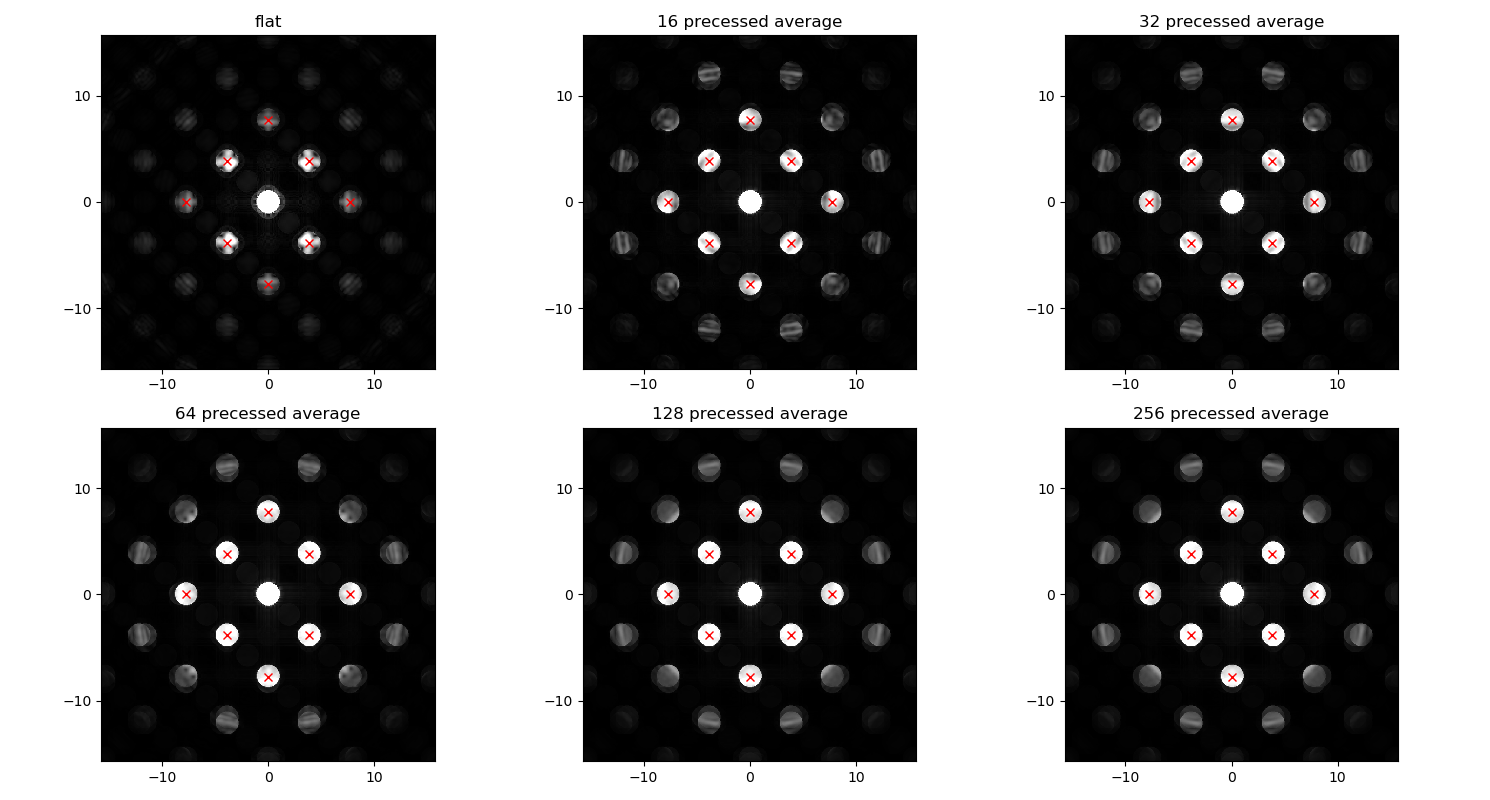

In [5]:
rotate = False
thresh, scale =.1, lambda x: maximum(1e-10,minimum(x,thresh)**.4)
figure('GT', figsize=(14.9, 8))
plt.subplot(231); plot_FT(scale(gt[rotate][0]))
plt.plot(spots[rotate][:,0], spots[rotate][:,1], 'rx'); plt.title('flat')
for k in range(5):
    plt.subplot(2,3,6-k); plot_FT(scale(gt[rotate][-k-1]))
    plt.plot(spots[rotate][:,0], spots[rotate][:,1], 'rx'); 
    plt.title(str(2**(N-k)) + ' precessed average')
plt.tight_layout()

In [6]:
# spot_rad = radius of spot, distance from center of one spot to edge of the next
spot_rad = {True:(1.1,1.5), False:(1.1,1.5)}

def predict(spots, strain):
    SPOTS = padSpots(spots[:,:2]) # [:,(x,y,z)] format
    SPOTS = SPOTS[:,(1,0,2)] # [:,ax=(0,1,2)] format
    scatter = empty(strain.shape+(spots.shape[0],), dtype=object)
    out = empty(strain.shape+(spots.shape[0],2))
    for i in range(strain.shape[0]):
        for j in range(strain.shape[1]):
            for k in range(spots.shape[0]):
                scatter[i,j,k] = array([linalg.solve(s.T, SPOTS[k])[1::-1] for s in strain[i,j]])
                out[i,j,k] = sum(scatter[i,j,k])/strain[i,j].shape[0]
    return scatter, out

def getCOMs(arr, points, rad, method='com', reference=None):
    # Assume points in [:,(x,y)] format
    # returns points in [:,(x,y)] format
    insz = arr.shape
    
    signal = pxm.ElectronDiffraction2D(arr.reshape((-1,)+insz[-3:])) # 2D array of diffraction patterns
    signal.set_diffraction_calibration(y[0][1]-y[0][0])

    midsz = signal.data.shape
    if points.ndim == 2:
        spg = SubpixelrefinementGenerator(signal, points)
    else:
        tmp = pxm.DiffractionVectors(points.reshape(midsz[:2]+(-1,2)))
        tmp.axes_manager.set_signal_dimension(2)
        spg = SubpixelrefinementGenerator(signal, tmp)
    
    if method == 'com':
        peaks = spg.center_of_mass_method(2*int(rad[1]/(y[1][1]-y[1][0])))
    elif method == 'lgm':
        peaks = spg.local_gaussian_method(2*int(rad[1]/(y[1][1]-y[1][0])))
    elif method == 'xc':
        peaks = spg.conventional_xc(2*int(rad[1]/(y[1][1]-y[1][0])), 
                                    int(rad[0]/(y[1][1]-y[1][0])),
                                    30)
    elif method == 'rxc':
        peaks = spg.reference_xc(reference,
                                 2*int(rad[1]/(y[1][1]-y[1][0])), 
                                 30)
    else:
        raise NotImplementedError("Your method, %s, is not currently supported.\nPlease choose from 'com', 'lgm', and 'xc'"%method)
        
    return peaks.data.reshape(*insz[:-2],-1,2)

names = [['Plain CoM','com'], ['Sqrt CoM','sqrt com'], ['Plain XC', 'xc'], 
         ['Sqrt XC', 'sqrt xc'], ['Plain RXC', 'rxc'], ['Sqrt RXC', 'sqrt rxc']]
coms, scatter, predicted = {},{},{}
# DP[rot][n precess] = (strain1,strain2,pixelsx,pixelsy) = array of images
# coms[(exact+name,rot)] = (n precess,n spot,2) = spot locations
# coms[(name,rot)] = (n precess,strain1,strain2,n spot,2) = array of spot locations
# scatter[(name,rot)] = (n precess,strain1,strain2,n spot,2) = array of spot locations
for rot in (True,False):
    for d in (coms, scatter, predicted):
        d.update({(name,rot): [] for _,name in names})
    coms.update({('exact '+name,rot): [] for _,name in names})

    for _,name in names:
        for k in range(N):
            arr, ref = DP[rot][k], gt[rot][k]
            if 'sqrt' in name:
                arr = sqrt(arr)
                ref = sqrt(ref)
                
            print('\rtype %s, level %d  '%(name+str(rot),k), end=' '*30)
            if 'rxc' in name:
                spots2 = getCOMs(ref, spots[rot], spot_rad[rot], 'xc') # use xc updated guess of spot locations
                coms[('exact '+name,rot)].append(getCOMs(ref, spots2, spot_rad[rot], 'rxc', ref)) # without strain
                coms[(name,rot)].append(getCOMs(arr, coms[('exact '+name,rot)][k], spot_rad[rot], 'rxc', ref)) # with strain
            else:
                coms[('exact '+name,rot)].append(getCOMs(ref, spots[rot], spot_rad[rot], 'xc' if 'xc' in name else 'com')) # without strain
                coms[(name,rot)].append(getCOMs(arr, coms[('exact '+name,rot)][k], spot_rad[rot], 'xc' if 'xc' in name else 'com')) # with strain
            
    print('\r' + ' '*100 + '\rCenters complete, rot='+str(rot))

    for _,name in names:
        for k in range(N):
            tmp = predict(coms[('exact '+name,rot)][k], strain[rot])
            scatter[(name,rot)].append(tmp[0])
            predicted[(name,rot)].append(tmp[1])
    print('Strained centers complete, rot='+str(rot))
    
for thing in coms:
    coms[thing] = array(coms[thing], dtype='float32')
for thing in scatter:
    scatter[thing] = array(scatter[thing])
    predicted[thing] = array(predicted[thing])

Centers complete, rot=True                                                                          
Strained centers complete, rot=True
Centers complete, rot=False                                                                         
Strained centers complete, rot=False


In [7]:
pixel_error = 0.0*max(abs(y[0][1]-y[0][0]), abs(y[1][1]-y[1][0])) # This error will be rounded to 0

def correctShapes(list1,list2,cut=False):
    # input shapes are one of:
    #     - (n precess,strain1,strain2,n spot,2)
    #     - (n precess,n spot,2)
    #     - (n precess,n spot,3)
    #     - (n spot,3)
    if list1.ndim < list2.ndim:
        if list1.ndim == 2:
            list1 = list1.reshape((1,)*(list2.ndim-list1.ndim) + list1.shape)
        else: 
            list1 = list1.reshape(list1.shape[:1]+(1,)*(list2.ndim-list1.ndim) + list1.shape[2:])
    elif list1.ndim > list2.ndim:
        return correctShapes(list2,list1,cut)
    if cut:
        return list1[...,:2], list2[...,:2]
    else:
        return list1, list2

def L2error(list1, list2):
    list1,list2 = correctShapes(list1,list2, cut=True)
    return maximum(0, sqrt(((list1-list2)**2).sum(-1))-pixel_error)/(1e-10+sqrt((list1**2).sum(-1)))

def angularerror(list1, list2): 
    list1,list2 = correctShapes(list1,list2, cut=True)
    thing = (list1*list2).sum(-1)
    r2 = maximum(1e-6, sqrt((list1**2).sum(-1)*(list2**2).sum(-1)))
    thing = minimum(thing/r2, 1)
    return maximum(0, arccos(thing)-pixel_error/r2**.5)/pi

def radialerror(list1, list2):
    list1,list2 = correctShapes(list1,list2, cut=True)
    r1, r2 = sqrt((list1**2).sum(-1)), sqrt((list2**2).sum(-1))
    tmp = r1-r2
    tmp[tmp>0] = maximum(0,tmp[tmp>0]-pixel_error)
    tmp[tmp<0] = minimum(0,tmp[tmp<0]+pixel_error)
    return tmp/r1

def HEADER(): print('|      Label      | Median |  Mean  |   STD  |   max  |\n'+'-'*55)
def FOOTER(): print('-'*55)
def PRINT(S,A): print('|%16.16s | % .3f | % .3f | % .3f | % .3f |'%(S, median(A), A.mean(), A.std(), abs(A).max()))
def TABLE(S,A): 
    frmt = '|%12.12s |  %.2f%% |  %.2f%% |  %.3f%% |  %.3f%% |  %+.3f%%  |   %.2f%%  |'
    n = [S]
    for i in range(3):
        B = 100*A[i]
        n.extend(((median(B)+B.mean())/2, B.std()))
    return frmt%tuple(n)

# errors[(name,rot)] = (metric,n precess,strain1,strain2,n spot)
errors = {k:concatenate([f(predicted[k],coms[k])[None] for f in (L2error, angularerror,radialerror)], axis=0)
         for k in predicted}

<IPython.core.display.Javascript object>


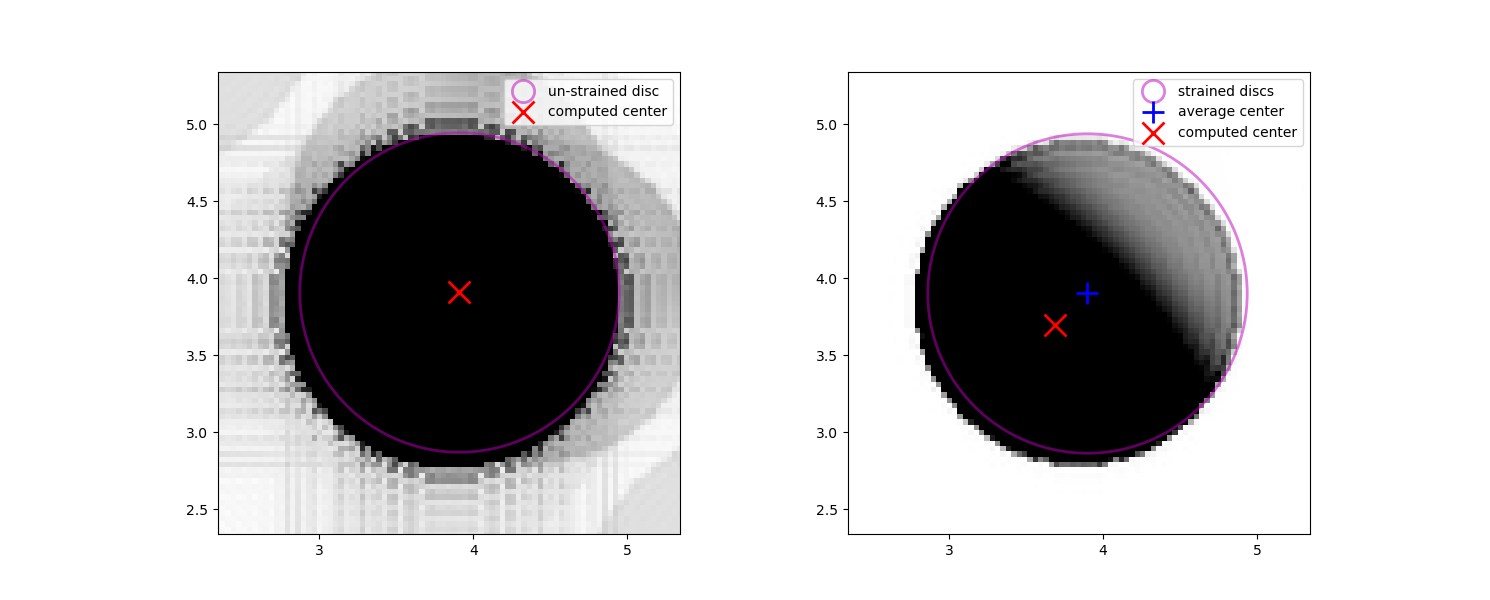

In [8]:
size = 1
key = 'com', rotate
ekey = ('exact ' + key[0], key[1])
k = errors[key][0,-1,:,:].argmax()
i,j,bad_spot = unravel_index(k,errors[key][0,-1,:,:].shape)
# print(repr(strain[i,j,k]))

figure('Predicted and computed spot locations')
thresh, scale = .08 if rotate else .04, lambda x: maximum(0,minimum(x,thresh)**1)
plt.subplot(121); plot_FT(-scale(sqrt(gt[rotate][-1]) if 'sqrt' in name else gt[rotate][-1]), cmap='gray')
if size==0: # small
    this_spot = spots[key[1]][bad_spot]
    ax = this_spot-.2*spot_rad[key[1]][1], this_spot+.2*spot_rad[key[1]][1]
    pms = {'markersize':16,'mew':2}
elif size==1: # medium
    this_spot = spots[key[1]][bad_spot]
    ax = this_spot-spot_rad[key[1]][1], this_spot+spot_rad[key[1]][1]
    pms = {'markersize':16,'mew':2}
else: # large
    ax = [(-12,-12),(12,12)]
    pms = {'markersize':8,'mew':2}
ax = ax[0][0], ax[1][0], ax[0][1], ax[1][1]
if size==1:
    plt.plot(coms[ekey][-1,:,0], coms[ekey][-1,:,1],'mo', label='un-strained disc', fillstyle='none', markersize=230, mew=2, alpha=.5)
plt.plot(coms[ekey][-1,:,0], coms[ekey][-1,:,1], 'rx', label='computed center', **pms)
plt.axis(ax); lgnd=plt.legend(); # plt.title('Unstrained sample')
lgnd.legendHandles[0]._legmarker.set_markersize(pms['markersize'])

plt.subplot(122); plot_FT(-scale(DP[rotate][-1,i,j]), cmap='gray')
if size==0: # small
    s = concatenate(scatter[key][-1,i,j])
    this_spot = predicted[key][-1,i,j,bad_spot]
    ax = this_spot-.2*spot_rad[key[1]][1], this_spot+.2*spot_rad[key[1]][1]
    f_name = '_big_zoom'
elif size==1: # medium
    s = scatter[key][-1,i,j,bad_spot]
    this_spot = spots[key[1]][bad_spot]
    ax = this_spot-spot_rad[key[1]][1], this_spot+spot_rad[key[1]][1]
    f_name = '_zoom'
else: # large
    ax = [(-12,-12),(12,12)]
    f_name = ''
ax = ax[0][0], ax[1][0], ax[0][1], ax[1][1]
plt.axis(ax)
if size==0:
    plt.plot(s[:,0], s[:,1],'m*', label='strained centers', **pms)
elif size==1:
    plt.plot(s[:,0], s[:,1],'mo', label='strained discs', fillstyle='none', markersize=230, mew=2, alpha=.5)
    
plt.plot(predicted[key][-1,i,j,:,0], predicted[key][-1,i,j,:,1], 'b+', label='average center', **pms)
plt.plot(coms[key][-1,i,j,:,0], coms[key][-1,i,j,:,1], 'rx', label='computed center', **pms)
lgnd = plt.legend(); lgnd.legendHandles[0]._legmarker.set_markersize(pms['markersize'])
# plt.title('Worst strained sample')
if alpha==1 and rotate==False:
    print('/home/rob/Dropbox (Cambridge University)/2018_strainTomography/Publications/Theory/Images/bad_prediction' + f_name + '.png')
#     plt.savefig('/home/rob/Dropbox (Cambridge University)/2018_strainTomography/Publications/Theory/Images/bad_prediction' + f_name + '.png', dpi=300)

# Summary:

## $\alpha = 0$

| <pre></pre> | L2 err | L2 std |Angle err|Angle std|Radial bias|Radial std|
|-------------|--------|--------|---------|---------|-----------|----------|
|   Plain CoM |  1.95% |  4.22% |  0.192% |  0.458% |  -0.815%  |   4.45%  |
|    Sqrt CoM |  1.75% |  2.20% |  0.127% |  0.226% |  -0.108%  |   2.84%  |
|    Plain XC |  0.46% |  1.62% |  0.041% |  0.102% |  +0.001%  |   1.70%  |
|     Sqrt XC |  0.45% |  1.11% |  0.039% |  0.101% |  +0.052%  |   1.20%  |
|   Plain RXC |  2.13% |  6.46% |  0.283% |  0.890% |  -1.095%  |   6.30%  |
|    Sqrt RXC |  0.86% |  3.14% |  0.078% |  0.252% |  -0.337%  |   3.23%  |

--------------------------------------------------------------------------------------
## $\alpha = .5$

| <pre></pre> | L2 err | L2 std |Angle err|Angle std|Radial bias|Radial std|
|-------------|--------|--------|---------|---------|-----------|----------|
|   Plain CoM |  0.40% |  0.91% |  0.042% |  0.111% |  +0.246%  |   0.94%  |
|    Sqrt CoM |  0.24% |  0.41% |  0.026% |  0.054% |  +0.124%  |   0.44%  |
|    Plain XC |  0.10% |  0.11% |  0.011% |  0.020% |  +0.023%  |   0.13%  |
|     Sqrt XC |  0.10% |  0.11% |  0.011% |  0.020% |  +0.018%  |   0.13%  |
|   Plain RXC |  0.14% |  0.41% |  0.015% |  0.029% |  +0.066%  |   0.43%  |
|    Sqrt RXC |  0.11% |  0.12% |  0.013% |  0.021% |  +0.034%  |   0.15%  |

--------------------------------------------------------------------------------------
## $\alpha = 1$

| <pre></pre> | L2 err | L2 std |Angle err|Angle std|Radial bias|Radial std|
|-------------|--------|--------|---------|---------|-----------|----------|
|   Plain CoM |  0.20% |  0.26% |  0.031% |  0.057% |  -0.035%  |   0.26%  |
|    Sqrt CoM |  0.12% |  0.14% |  0.023% |  0.032% |  +0.004%  |   0.15%  |
|    Plain XC |  0.05% |  0.06% |  0.008% |  0.015% |  +0.003%  |   0.06%  |
|     Sqrt XC |  0.04% |  0.06% |  0.008% |  0.013% |  -0.003%  |   0.06%  |
|   Plain RXC |  0.06% |  0.11% |  0.010% |  0.028% |  -0.007%  |   0.10%  |
|    Sqrt RXC |  0.05% |  0.09% |  0.010% |  0.021% |  +0.001%  |   0.08%  |

--------------------------------------------------------------------------------------
## $\alpha = 2$

| <pre></pre> | L2 err | L2 std |Angle err|Angle std|Radial bias|Radial std|
|-------------|--------|--------|---------|---------|-----------|----------|
|   Plain CoM |  0.08% |  0.14% |  0.013% |  0.035% |  +0.018%  |   0.12%  |
|    Sqrt CoM |  0.10% |  0.08% |  0.016% |  0.021% |  +0.029%  |   0.09%  |
|    Plain XC |  0.04% |  0.11% |  0.009% |  0.026% |  +0.001%  |   0.09%  |
|     Sqrt XC |  0.05% |  0.10% |  0.008% |  0.024% |  -0.007%  |   0.08%  |
|   Plain RXC |  0.08% |  0.19% |  0.013% |  0.045% |  -0.004%  |   0.16%  |
|    Sqrt RXC |  0.06% |  0.15% |  0.011% |  0.035% |  -0.003%  |   0.12%  |

# General Comparison
| <pre>            </pre> | $\alpha = 0$ | $\alpha =.5$ | $\alpha = 1$ | $\alpha = 2$ |
|-------------------------|--------------|--------------|--------------|--------------|
|  Plain Centres of Mass  |     1.95%    |   0.40%&nbsp;|     0.20%    |     0.08%    |
|  Sqrt Centres of Mass   |     1.75%    |   0.24%      |     0.12%    |     0.10%    |
| Plain Cross Corellation |     0.46%    |   0.10%      |     0.05%    |     0.04%    |
| Sqrt Cross Corellation  |     0.45%    |   0.10%      |     0.04%    |     0.05%    |
| Plain Cross Referenced  |     2.13%    |   0.14%      |     0.06%    |     0.08%    |
| Sqrt Cross Referenced   |     0.86%    |   0.11%      |     0.05%    |     0.06%    |


In [9]:
print('alpha = ', alpha)
for name in names:
    print(TABLE(name[0], concatenate((errors[(name[1],False)][:,-1],
                                      errors[(name[1],True)][:,-1]), axis=-1)))
print('\nalpha = ', 0)
for name in names:
    print(TABLE(name[0], concatenate((errors[(name[1],False)][:,0],
                                      errors[(name[1],True)][:,0]), axis=-1)))

alpha =  0.5
|   Plain CoM |  0.40% |  0.91% |  0.042% |  0.111% |  +0.246%  |   0.94%  |
|    Sqrt CoM |  0.24% |  0.41% |  0.026% |  0.054% |  +0.124%  |   0.44%  |
|    Plain XC |  0.10% |  0.11% |  0.011% |  0.020% |  +0.023%  |   0.13%  |
|     Sqrt XC |  0.10% |  0.11% |  0.011% |  0.020% |  +0.018%  |   0.13%  |
|   Plain RXC |  0.14% |  0.41% |  0.015% |  0.029% |  +0.066%  |   0.43%  |
|    Sqrt RXC |  0.11% |  0.12% |  0.013% |  0.021% |  +0.034%  |   0.15%  |

alpha =  0
|   Plain CoM |  1.95% |  4.22% |  0.192% |  0.458% |  -0.815%  |   4.45%  |
|    Sqrt CoM |  1.75% |  2.20% |  0.127% |  0.226% |  -0.108%  |   2.84%  |
|    Plain XC |  0.46% |  1.62% |  0.041% |  0.102% |  +0.001%  |   1.70%  |
|     Sqrt XC |  0.45% |  1.11% |  0.039% |  0.101% |  +0.052%  |   1.20%  |
|   Plain RXC |  2.13% |  6.46% |  0.283% |  0.890% |  -1.095%  |   6.30%  |
|    Sqrt RXC |  0.86% |  3.14% |  0.078% |  0.252% |  -0.337%  |   3.23%  |


In [10]:
# print('Precessed, alpha = ', alpha)
# for name in names:
#     tmp = (TABLE(name[0], errors[(name[1],False)][:,-1]).split(' |',1), # rotate=False
#            TABLE(name[0], errors[(name[1],True)][:,-1]).split(' |',1)) # rotate=True
#     print(tmp[0][0]+' |<pre> </pre>|'+tmp[0][1]+'<pre></pre>|'+tmp[1][1])

# print('\nUn-precessed values:')
# for name in names:
#     tmp = (TABLE(name[0], errors[(name[1],False)][:,0]).split(' |',1), # rotate=False
#            TABLE(name[0], errors[(name[1],True)][:,0]).split(' |',1)) # rotate=True
#     print(tmp[0][0]+' |<pre> </pre>|'+tmp[0][1]+'<pre></pre>|'+tmp[1][1])


<IPython.core.display.Javascript object>


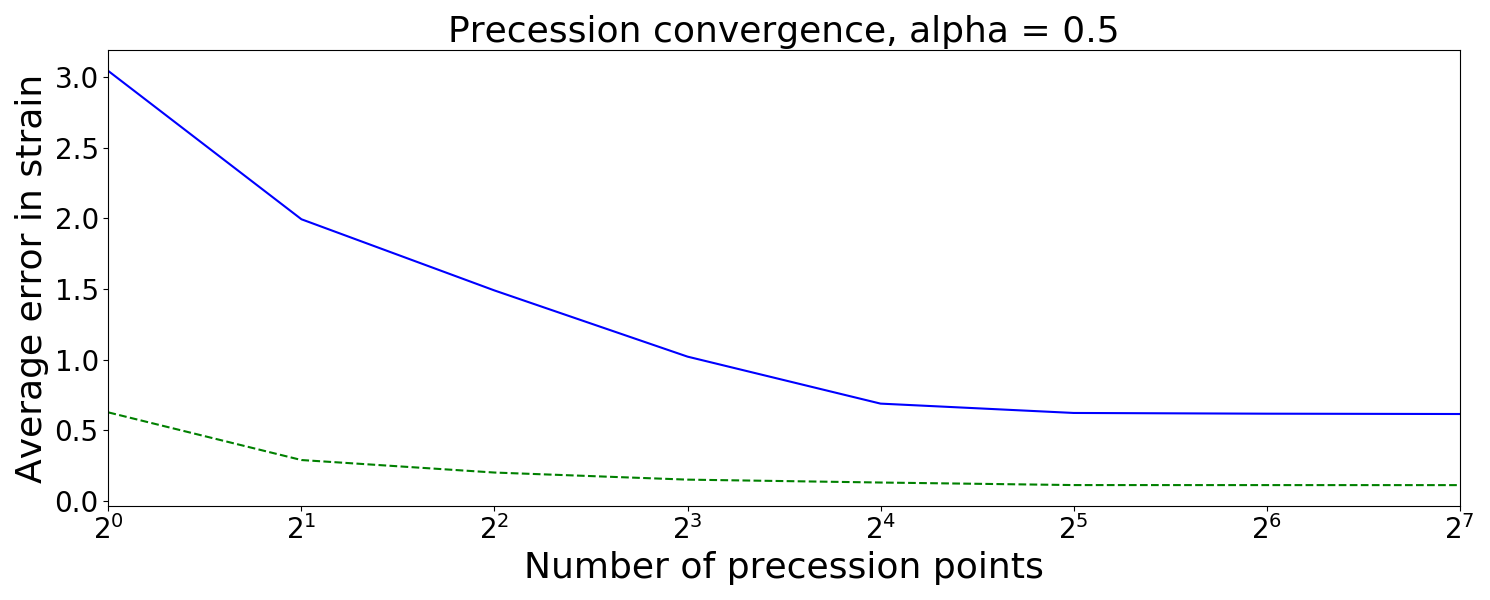

In [11]:
tmp = names
tmp = [name for name in names if name[1] in ('com','xc')]
plt.rcParams.update({'axes.labelsize': 26, 'axes.titlesize':26,'xtick.labelsize':20,'ytick.labelsize':20})
figure('Precession convergence')
for name in tmp:
    plt.plot([2**i for i in range(N)], 50*(errors[(name[1],False)][0].mean((1,2,3)) + errors[(name[1],True)][0].mean((1,2,3))), label=name[0])
if len(tmp)==len(names):
    plt.legend(loc='upper right')
plt.xlim(1,2**(N-1)); plt.gca().set_xscale('log', basex=2)
plt.xlabel('Number of precession points'); plt.ylabel('Average error in strain');
plt.title('Precession convergence, alpha = '+str(alpha))
plt.tight_layout()
if alpha==2:
    plt.savefig('/home/rob/Dropbox (Cambridge University)/2018_strainTomography/Publications/Theory/Images/precession_convergence_multislice.png', dpi=300)
else:
    plt.savefig('/home/rob/Dropbox (Cambridge University)/2018_strainTomography/Publications/Theory/Images/precession_convergence_multislice%d.png'%(2*alpha), dpi=300)